In [1]:
#fastai study group.  learning my way around Kaggle.  Not competing yet.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [3]:
from fastai.tabular.all import *
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/test_features.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/sample_submission.csv')]

In [4]:
train_features = pd.read_csv(path/'train_features.csv')
test_features = pd.read_csv(path/'test_features.csv')
train_targets = pd.read_csv(path/'train_targets_scored.csv')
train_drugs = pd.read_csv(path/'train_drug.csv')
sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
train_features.shape, train_targets.shape

((23814, 876), (23814, 207))

In [6]:
#data prep
categorical = ['cp_type', 'cp_time', 'cp_dose']
continuous = [i for i in train_features.columns if i not in ['cp_type', 'cp_time', 'cp_dose', 'sig_id']]
dep_var = [i for i in train_targets.columns if i != 'sig_id']
train_features[dep_var] = train_targets[dep_var]
train_features.shape

(23814, 1082)

In [7]:
# We have appended the targets to the features dataframe
train_features.iloc[1:5,-5:-1]

,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [8]:
n_train = np.rint(train_features.shape[0]*0.8).astype(int)
n_train

19051

In [9]:
indices = np.random.permutation(train_features.shape[0])
train_idx, test_idx = indices[:n_train], indices[n_train:]
splits = (list(train_idx), list(test_idx))


In [10]:
procs = [FillMissing, Categorify, Normalize]
data = TabularPandas(train_features, procs=procs, cat_names=categorical,
                    cont_names=continuous, y_names=dep_var, splits = splits)

In [11]:
len(data.train), len(data.valid)

(19051, 4763)

In [12]:
data.show(10)


In [13]:
#data loaders
dls = data.dataloaders(512)

In [14]:
#setup learner
learn = tabular_learner(dls, layers=[600,300], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0020892962347716093)

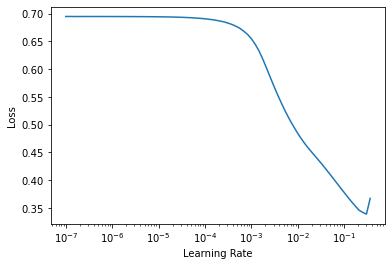

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,time
0,0.201899,0.061095,00:03
1,0.084893,0.019150,00:03
2,0.045377,0.017357,00:03
3,0.029353,0.016619,00:03
4,0.021976,0.016231,00:03
5,0.018281,0.016041,00:03
6,0.016173,0.015851,00:04
7,0.014864,0.015774,00:03
8,0.014025,0.015740,00:03
9,0.013532,0.015731,00:03


In [17]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

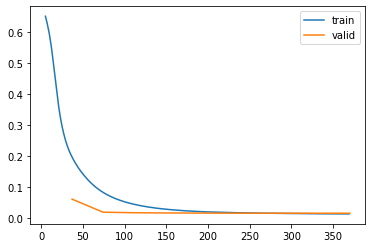

In [18]:
learn.recorder.plot_loss()

In [19]:
#Get Predictions for Submission
#We follow the guide to setting up a test set here: https://forums.fast.ai/t/a-brief-guide-to-test-sets-in-v2-you-can-do-labelled-now-too/57054
#testset
test_dl = dls.test_dl(test_features)

In [20]:
test_dl.show(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

In [21]:
preds,_ = learn.get_preds(dl=test_dl)

In [22]:
preds_df = pd.DataFrame(preds).astype("float")

In [23]:
preds_df.head

<bound method NDFrame.head of                0             1             2         3         4         5    \
0     3.113861e-04  6.565699e-04  3.147190e-04  0.032195  0.022542  0.002518   
1     1.484387e-04  9.930468e-04  4.185594e-03  0.001926  0.001476  0.005828   
2     7.538836e-10  9.353788e-10  1.277420e-08  0.000963  0.000478  0.000005   
3     4.345732e-05  4.141060e-05  1.748083e-03  0.009224  0.002822  0.001549   
4     1.479183e-03  2.535433e-04  8.146965e-04  0.012591  0.020705  0.001511   
...            ...           ...           ...       ...       ...       ...   
3977  4.995743e-05  1.730514e-04  4.429920e-04  0.003985  0.000888  0.000273   
3978  2.285409e-03  7.790613e-04  3.511072e-04  0.003313  0.022117  0.001378   
3979  2.150798e-04  2.629433e-04  2.848317e-04  0.005053  0.028723  0.005048   
3980  1.528690e-04  1.111971e-04  4.298763e-04  0.021718  0.048009  0.007934   
3981  1.651547e-04  2.722750e-04  3.492126e-04  0.010057  0.017687  0.002686   

         

In [24]:
submission = sub
submission[dep_var] = preds_df
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0

In [25]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000311,0.000657,0.000315,0.032195,0.022542,0.002518,0.002121,0.001741,0.000272,...,0.000100,0.000526,0.001417,0.001005,0.000364,0.000206,0.000032,0.000868,0.000454,0.000877
1,id_001897cda,0.000148,0.000993,0.004186,0.001926,0.001476,0.005828,0.001726,0.018968,0.005597,...,0.000477,0.002641,0.005322,0.000316,0.018781,0.000452,0.015695,0.001779,0.011504,0.002333
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000043,0.000041,0.001748,0.009224,0.002822,0.001549,0.000895,0.003353,0.000166,...,0.000152,0.000308,0.000720,0.031302,0.004198,0.000048,0.000954,0.000525,0.002083,0.001409
4,id_0027f1083,0.001479,0.000254,0.000815,0.012591,0.020705,0.001511,0.005048,0.001609,0.000110,...,0.000465,0.000314,0.004018,0.000823,0.000352,0.000270,0.000062,0.001961,0.001714,0.003184


In [26]:
submission.to_csv('submission.csv', index=False)